<p><b>Intro</b>: I performed the following analysis for my intermediate data programming with Python class. The assignment was to select a data set, identify research questions and then perform an analysis to answer said questions. This notebook is a revised and streamlined version of my assignment, focusing more on the analysis, results and technical challenges rather than the academic rubric. E.g. you probably don't want to read a paragraph on how I met the "join two datasets" portion of the rubric, nor do you need to see how I split the data ingestion and data analysis into two separate .py files. For ease of use I've put most of my write-up and my python code into a Jupyter notebook for easier review, revision and recreation of my results. I've also made a few tweaks or revisions here and there either to my approach or the write-up. Finally, I've added a section at the end where I discuss future related analyses I'd like to perform. For a faster summary the PDF in this GitHub repository provides a high level overview of the results.</p> 

<p> Every year the NBA holds a combine where player's physical attributes in addition to certain basketball skillets are tested. Physical attributes like height, weight, body fat percentage, wing span, hand size, height and reach are measured, in addition to athletic attributes like speed, agility, leaping ability and strength. Players are also evaluated in terms of their shooting ability, as far as the % of shots they make from various parts of the floor. The current thinking is that the combine data in addition to the NBA's other evaluation methods, give teams the data they need to make smart draft day decisions. However, the value of the combine is being challenged and there are those that don't think any of the measurements taken at the combine are relevant to in game performance. </p> 

<p>Recently, NBA Superstar Kevin Durant made a statement claiming that the <a herf="https://abcnews.go.com/Sports/kevin-durant-calls-nba-combine-waste-time-top/story?id=47338234">NBA combine wasn't worth it</a> for future NBA prospects, as the events or things tested have nothing to do with on court performance. To support his claim Kevin noted his own experience as being ranked last as far as strength, speed and the like, and then going on to be far and away the best basketball player in his draft class, if not well over 90% of all draft classes. The goal of this project is to attempt to validate Kevin's claim(s) via evaluating the following research questions:</p>

1) How good are the NBA's evaluation methods overall? Like most sports the NBA has had its share of "draft busts", players that fail to meet expectations relative to their draft position. By looking at the trends around draft position vs. in game performance, we'll attempt to answer the question: "how often does the NBA get it right?"

2) Is there any relationship between in combine measurements like reach, wingspan, agility and the like with in game performance? For example: do players with higher agility and speed numbers tend to steal the ball more? In short: we're going to evaluate Kevin's claim that the combine measureables are irrelevant, by determining if there is a significant relationship between combine measurements and on the court performance, and if such a relationship does exist we'll attempt to create a model to predict future NBA performance from the combine. 

3) Is there any relationship between draft position and combine performance, i.e. are there any events or measurements at the NBA combine that strongly correlate with being selected higher in the draft? This question wil get to another part of Kevin's argument as far as the combine being a waste of time for NBA prospects. 

<P> For questions two and three, I will use the <a href="https://www.basketball-reference.com/about/ws.html"> win share</a> metric that attempts to quantify how many wins a particular athlete has contributed to his team, as well as the PPG or points per game metric. I used win share as the overall player value metric because it produces fewer anomolies and is harder to "game" than the player efficiency rating(PER) metric that is also used to evaluate a player's overall contribution. E.g. your PER can go up if you take a lot of shots even if you miss them, because the shots made % (FG%) of all NBA players exceed the minimum threshold where you would be penalized for missing shots shots.</P> 


Approach wise: 

1. I'm going to download NBA statistics for several seasons 
2. Acquire combine data for the players represented in the above data set
3. Use visualizations for the initial exploratory analysis, one of the key ones will be a correlation matrix to see if there are any strong relationships between the variables. 
4. Use linear model visualizations to illustrate how strong or weak certain relationships are 
5. Use regression and/or machine learning models if something significant is identified. 


Caveats: 
1. Not all players participate in the combine or even in all events. 
2. I used a dataset of combine data from Kaggle that covers the 2009 through 2016 NBA combines, the data set isn't as complete as I would like but I felt it was enough to determine if there was a general pattern. In a future version I'm going to download a more comprehensive dataset via the NBA API and extend the study back to the early 90s. 
3. For the purposes of evaluating draft position vs. performance I had data on ~200 players and for the combine I had 99 players, given that there are usually only around 360 active NBA players at a given moment this seemed relatively sufficient, but I would've liked to have more data

In [1]:
# first we import all the packages we're going to use for this project 
# it's worth noting that there are packages here that this version of the project didn't use. 

import pandas as pd
import math
import os 
import glob2 as glob
import numpy as np
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt 
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
%matplotlib inline

In [3]:
# I used the glob package to open up a directory containing all of the csv files with the NBA season by season 
# player statistics and then merge them all into one data frame, where each subsequent csv is appended to the 
# end of the data frame. 


nba_df = pd.concat([pd.read_csv(f, header=1) for f in glob.glob(os.path.join('nba_stats', "*.csv"))], sort=False)
nba_df.shape

(2200, 33)

In [4]:
# according to the NBA you have to play 58 games in a season for 
# that season to be statistically significant as far as qualifying to be in the statistical rankings. 
# So we'll sort out only the seasons where an individual athlete played in at least 58 games. 


nba_min = nba_df[(nba_df['G'] >= 58)]
nba_min.shape



(1784, 33)

For this round of the analysis I just focused on whether or not an individual athlete had managed to complete a single 58 game season rather than having a minimum number of seasons. I.e. evaluating the ability of a given player to produce at least one statistically significant (and hopefully above average) NBA season, rather than evaluating longevity.

In [5]:
# sort out just the statistics we want to use in our analysis, dropping statistics due to being
# functions of other stats (E.g. FG%) or just to simplify our analysis. 


nba_subset = nba_min[['Player', 'Season', 'WS', 'G', 'MP', 'ORB', 'DRB',
                                'TRB','AST', 'STL', 'BLK', 'PTS', 'TOV']]


In [7]:
# calculate points per game, since it's not in the original data set 

nba_subset.loc[:,'PPG'] = nba_subset['PTS'] / nba_subset['G']

Now that we have the data for all of the NBA players, let's sort it by Win Share and see who the leaders are over this seven year time period. 

In [8]:
nba_subset = nba_subset.sort_values('WS', ascending=False)
nba_subset.head(30)

,Player,Season,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,PTS,TOV,PPG
0,LeBron James,2012-13,19.3,76,2877,97,513,610,551,129,67,2036,226,26.789474
1,Kevin Durant,2013-14,19.2,81,3122,58,540,598,445,103,59,2593,285,32.012346
2,Kevin Durant,2012-13,18.9,81,3119,46,594,640,374,116,105,2280,280,28.148148
3,Stephen Curry,2015-16,17.9,79,2700,68,362,430,527,169,15,2375,262,30.063291
4,James Harden,2014-15,16.4,81,2981,75,384,459,565,154,60,2217,321,27.370370
5,Chris Paul,2014-15,16.1,82,2857,52,324,376,838,156,15,1564,190,19.073171
6,LeBron James,2013-14,15.9,77,2902,81,452,533,488,121,26,2089,270,27.129870
7,Stephen Curry,2014-15,15.7,80,2613,56,285,341,619,163,16,1900,249,23.750000
8,James Harden,2017-18,15.4,72,2551,41,348,389,630,126,50,2191,315,30.430556
9,James Harden,2018-19,15.2,78,2867,66,452,518,586,158,58,2818,387,36.128205


In [9]:
# count uniques in the player column just to see 
# the number of athletes represented in the dataset 

nba_subset['Player'].nunique()

546

The NBA player data set contains data on 546 total players across 1,784 "seasons" from the perspective of seasons represented for the players as whole, this also means that on average there are a little over three seasons per player. Looking at the data on the top 30 players, we can calso see that only 12 players are represented in the top 30 seasons by win share. This suggests that in a typical draft few or none of those players will join the league's top echelons. Given this, we will evaluate drafting based on the probability that a player selected in the top 15 of draft is at minimum above average and ideally in the top 25% of NBA players statistically. 

<P>Now that we have the NBA data set we'll use for our analysis, let's walk through some high level stats for the dataset as a whole 

In [10]:
nba_subset.describe()

,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,PTS,TOV,PPG
count,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000,1784.000000
mean,4.431783,72.959641,1875.687220,83.443386,259.918722,343.361547,177.231502,60.549888,38.643498,826.759529,105.327915,11.243486
std,2.762365,7.122716,561.598857,66.088013,135.242470,189.523330,143.882932,31.446378,35.408134,423.336627,59.487959,5.514774
min,1.000000,58.000000,482.000000,5.000000,28.000000,47.000000,8.000000,6.000000,0.000000,87.000000,11.000000,1.403226
25%,2.500000,68.000000,1434.500000,34.000000,164.000000,206.000000,76.000000,38.000000,15.000000,506.000000,61.000000,7.114316
50%,3.600000,74.000000,1901.500000,61.000000,223.000000,296.000000,130.000000,54.000000,27.000000,756.000000,94.000000,10.102417
75%,5.700000,79.000000,2304.500000,114.000000,328.250000,433.000000,230.000000,78.000000,51.000000,1055.000000,134.000000,14.139881
max,19.300000,83.000000,3167.000000,440.000000,848.000000,1247.000000,907.000000,191.000000,269.000000,2818.000000,464.000000,36.128205


Some key pieces of information about our dataset includes:

* Average Win Share is 4.43 games with a standard deviation of 2.76 games 
* Average PPG is 11.24 with a standard deviation of 5.51 
* The 75% percentile is interesting as well, 5.7  for Win Share and 14.13 for PPG

We'll use the average win share and PPG metrics  to see how the players in our combine data sets compare to the broader NBA dataset as a group, since there will be players in the NBA player data set that are not in the combine data set. We'll also use the data to evaluate things ranging from draft effectiveness to what % of NBA first round picks have produced elite seasons in terms of seasons in the top 25% of the league statistically. 

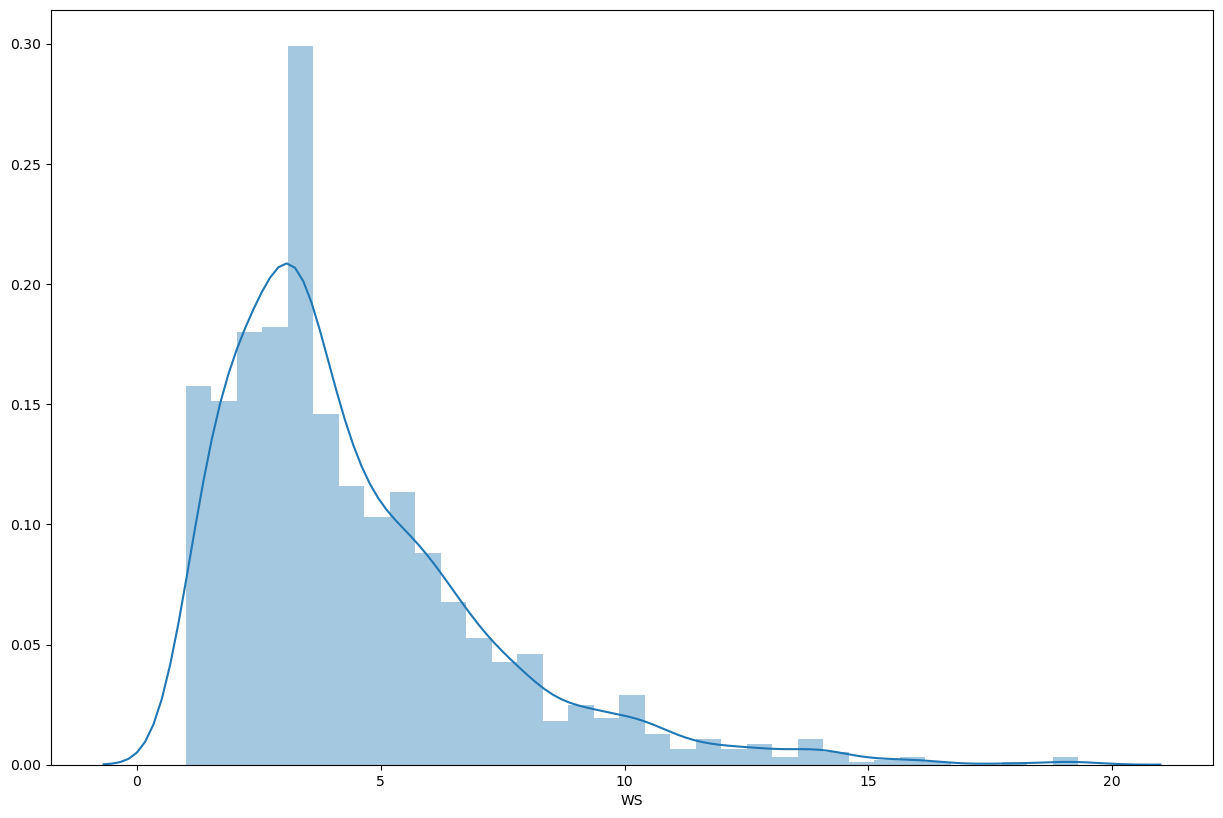

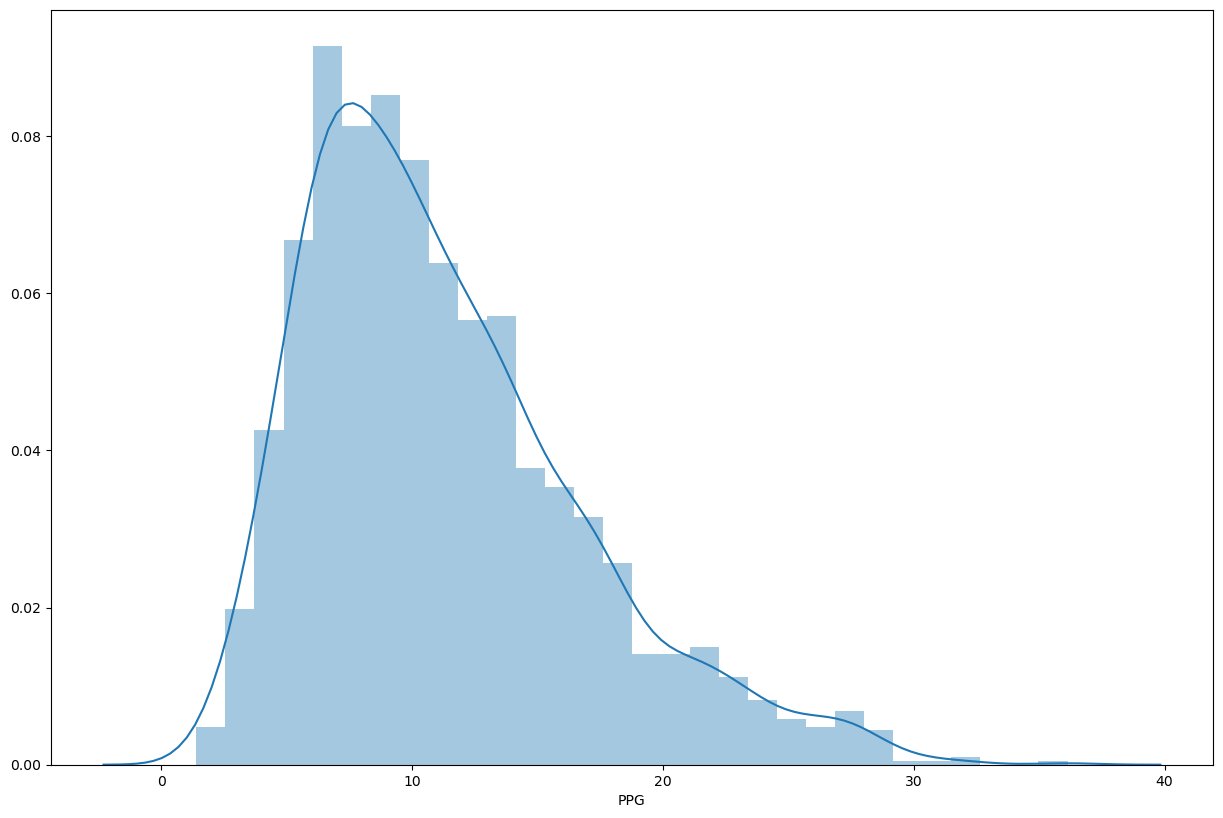

In [84]:
# let's look at the distribution of PPG and win share

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(nba_subset['WS'])


plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(nba_subset['PPG'])




PPG is closer to being a normal distribution, but overall both distributions are skewed to the right. This more or less means that most players are grouped near the average, and the exceptional ones are rare/outliers, which suggests that our analysis is probably going to be better at predicting "good" rather than great players, as the great ones are so rare. 

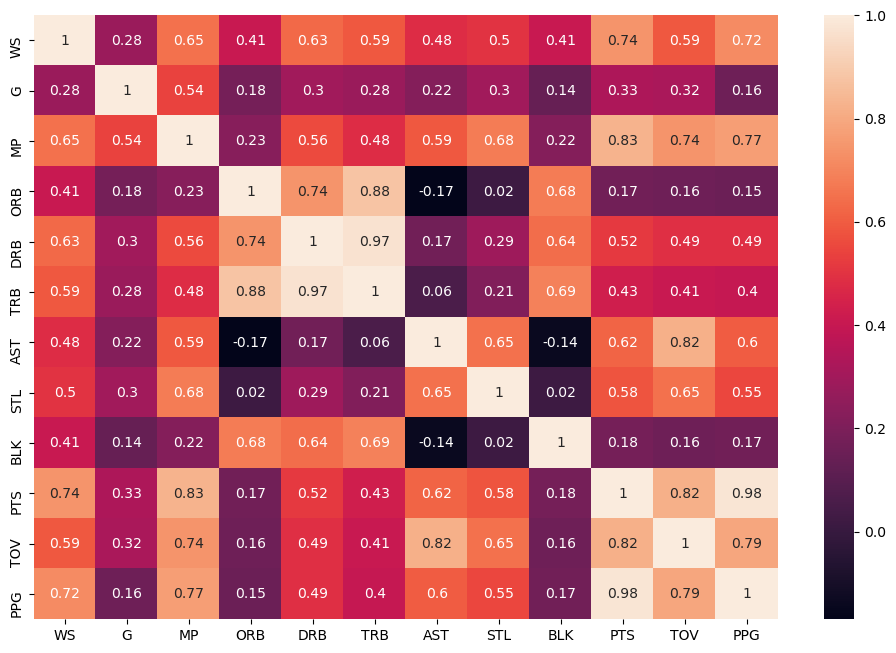

In [85]:
# Let's quickly evaluate our primary metric, how does WS correlate to other statistics in our data set?

# this code sets the size of our plots so they're easier to read 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

#calculates correlations and then uses the heatmap function of seaborn to plot it 
corr_ws = nba_subset.corr().round(2)
sns.heatmap(data=corr_ws, annot=True)


The numbers in the above table are "Pearson's correlation coefficients" and they indicate how linear the relationship is as far as how one number behaves as the other changes. The coefficients are being -1 and 1, where 1 means they would move perfectly in synch, while -1 means they move in opposite directions. A "strong" relationship would be a coefficient of +/- 0.7 or above. 

Looking through the data we see a variety of patterns, and they all fairly logic and not particularly unexpected:

* Turnover has a high correlation with PPG, Points, Assists and Minutes Played, which suggests that the players who touch the ball the most due to their scoring, assists and the like are just more often in a position to make a mistake. It's also worth noting that the turnover number is the total number of turnovers, it's not expressed in terms of turnovers per touches. 
* Steals has a good correlation with assists and turnovers, which is interesting as it suggets that the players who turn over the ball the most are often the ones causing their opponents to do the same. It's also possible that in the process of stealing the ball they sometimes lose control and get both stats at the same time 
* TRB and BLKs have a strong correlation, which is a case of mathematics proving what makes intuitive sense, namely: players that good at getting rebounds also tend to be good shot blockers. Again, this makes sense: if you have the height, leaping ability and good awareness of where the ball is to get a rebound, you can probably also apply those skills to blocking shots. 
* Winshare has its highest correlations with PPG (0.72), Defensive Rebounds (0.63) and Minutes Played (0.65), none of this is surprising, as it means that players who score a lot, take scoring opportunities away from opponents and are durable enough to play a lot of minutes are going to help their teams more. What's interesting are the items that weren't in the strong correlation (0.7 or better) or at least close category, namely: offensive rebounds (0.41) and assists (0.48), which probably means that the giving your team extra scoring chances or passing the ball to others that score isn't as valuable to your team as just scoring yourself. 


<p>For purposes of a visual let's make a linear regression plot of PPG vs. Win Share, just so we have a reference image of what a strong correlation looks like.

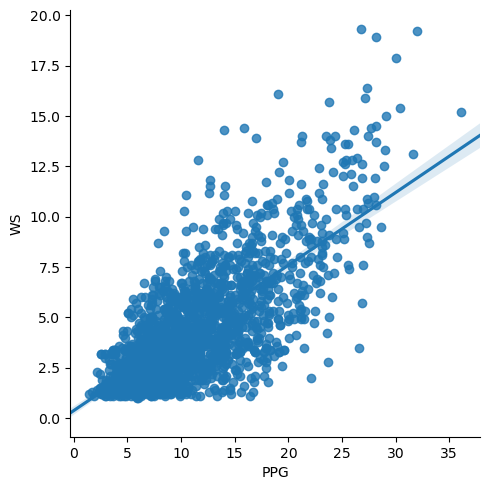

In [12]:


sns.lmplot(x="PPG", y="WS", data=nba_subset)


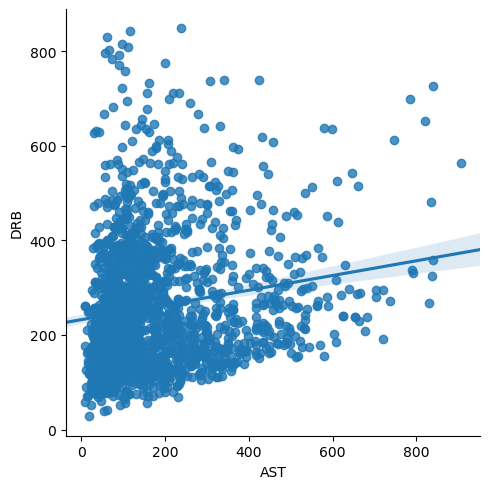

In [23]:
# Also for reference let's plot one of the weak correlations, assists vs. defensive rebounds

sns.lmplot(x="AST", y="DRB", data=nba_subset)

As we can see from the above, we have a very general trend line with a fairly weak slope and data scattered all over the place. IF the NBA Combine does in fact relate to in game performance, our linear model plots will look more like the first graph than they will the second. Before we merge the player stats data with the combine data, let's aggregate the data by player and then sort in descending order by Win Share.

In [13]:
nba_players = nba_subset.groupby('Player').mean()
nba_players = nba_players.sort_values('WS', ascending=False)

nba_players.head(30)

,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,PTS,TOV,PPG
Player,,,,,,,,,,,,
Kevin Durant,14.416667,73.666667,2652.666667,42.000000,508.166667,550.166667,383.833333,77.000000,91.833333,2046.000000,230.833333,27.626969
James Harden,14.414286,77.857143,2890.428571,66.142857,398.000000,464.142857,600.142857,136.428571,46.285714,2261.714286,345.857143,29.040460
LeBron James,14.350000,75.666667,2800.166667,89.000000,489.666667,578.666667,576.166667,111.833333,51.000000,1998.833333,277.833333,26.383333
Stephen Curry,13.416667,77.166667,2685.166667,55.833333,301.000000,356.833333,539.333333,136.666667,16.500000,1969.000000,246.000000,25.548036
Chris Paul,11.757143,66.428571,2201.142857,42.142857,257.571429,299.714286,630.000000,137.142857,11.714286,1210.285714,159.285714,18.146636
Karl-Anthony Towns,11.350000,80.750000,2780.000000,256.500000,701.250000,957.750000,209.750000,61.250000,120.250000,1796.750000,198.500000,22.283774
Nikola Joki_,11.250000,77.500000,2473.500000,211.500000,622.500000,834.000000,519.000000,99.000000,58.000000,1494.500000,229.000000,19.258333
Rudy Gobert,11.100000,76.250000,2352.750000,274.000000,605.750000,879.750000,114.500000,56.000000,181.250000,916.000000,125.500000,11.846473
Russell Westbrook,11.033333,77.166667,2709.833333,129.666667,539.833333,669.500000,743.166667,144.833333,23.666667,1988.000000,342.000000,25.784504


It required going out to three decimal points, but Kevin Durant is the leader for his time frame. 

In [14]:
# validate how many athletes are included 

total_athletes = len(nba_players)
total_athletes 

546

In [15]:
# Use pandas import combine data


all_combine_data = pd.read_csv('new_data/nba_draft_combine_all_years.csv')
all_combine_data

,Unnamed: 0,Player,Year,Draft pick,Height (No Shoes),Height (With Shoes),Wingspan,Standing reach,Vertical (Max),Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,0,Blake Griffin,2009,1.0,80.50,82.00,83.25,105.0,35.5,140.5,32.0,137.0,248.0,8.2,NaN,NaN,22.0,10.95,3.28
1,1,Terrence Williams,2009,11.0,77.00,78.25,81.00,103.5,37.0,140.5,30.5,134.0,213.0,5.1,NaN,NaN,9.0,11.15,3.18
2,2,Gerald Henderson,2009,12.0,76.00,77.00,82.25,102.5,35.0,137.5,31.5,134.0,215.0,4.4,NaN,NaN,8.0,11.17,3.14
3,3,Tyler Hansbrough,2009,13.0,80.25,81.50,83.50,106.0,34.0,140.0,27.5,133.5,234.0,8.5,NaN,NaN,18.0,11.12,3.27
4,4,Earl Clark,2009,14.0,80.50,82.25,86.50,109.5,33.0,142.5,28.5,138.0,228.0,5.2,NaN,NaN,5.0,11.17,3.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,512,Peter Jok,2017,NaN,76.25,77.75,80.00,102.0,31.0,133.0,26.5,128.5,202.0,11.0,8.25,9.50,NaN,11.34,3.41
513,513,Rawle Alkins,2017,NaN,74.50,75.75,80.75,99.0,40.5,139.5,31.5,130.5,223.0,11.0,8.75,10.00,NaN,11.99,3.30
514,514,Sviatoslav Mykhailiuk,2017,NaN,78.50,79.50,77.00,100.0,33.0,133.0,27.0,127.0,220.0,11.4,8.00,9.25,NaN,12.40,3.53
515,515,Thomas Welsh,2017,NaN,83.50,84.50,84.00,109.5,NaN,NaN,NaN,NaN,254.0,10.9,9.00,10.50,NaN,NaN,NaN


Merge combine data with the NBA player statistics, even if we don't have a complete set of combine data for that particular player so we at least have the athlete's draft position as that's not in the NBA player statistics data set. 


In [16]:
combine_nba_merge = pd.merge(nba_players, all_combine_data, on='Player')
combine_nba_merge


,Player,WS,G,MP,ORB,DRB,TRB,AST,STL,BLK,...,Vertical (Max Reach),Vertical (No Step),Vertical (No Step Reach),Weight,Body Fat,Hand (Length),Hand (Width),Bench,Agility,Sprint
0,James Harden,14.414286,77.857143,2890.428571,66.142857,398.000000,464.142857,600.142857,136.428571,46.285714,...,140.5,31.5,135.0,222.0,10.1,NaN,NaN,17.0,11.10,3.13
1,Stephen Curry,13.416667,77.166667,2685.166667,55.833333,301.000000,356.833333,539.333333,136.666667,16.500000,...,132.5,29.5,126.5,181.0,5.7,NaN,NaN,10.0,11.07,3.28
2,Rudy Gobert,11.100000,76.250000,2352.750000,274.000000,605.750000,879.750000,114.500000,56.000000,181.250000,...,144.0,25.0,140.0,238.0,4.4,9.75,10.00,7.0,12.85,3.57
3,Anthony Davis,10.400000,68.333333,2376.333333,172.333333,533.333333,705.666667,127.333333,91.833333,164.333333,...,NaN,NaN,NaN,222.0,7.9,9.00,8.50,NaN,NaN,NaN
4,Damian Lillard,10.042857,78.428571,2843.857143,49.571429,277.428571,327.000000,497.000000,76.142857,24.428571,...,135.0,34.5,130.0,189.0,5.9,8.75,9.75,13.0,11.15,3.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,Nate Wolters,1.200000,58.000000,1309.000000,33.000000,116.000000,149.000000,187.000000,35.000000,15.000000,...,NaN,NaN,NaN,196.0,5.5,8.25,8.75,8.0,NaN,NaN
217,Semi Ojeleye,1.200000,73.000000,1150.000000,37.000000,124.000000,161.000000,20.000000,21.000000,4.000000,...,142.5,35.0,137.0,241.0,5.5,8.75,9.50,NaN,10.58,3.16
218,Dillon Brooks,1.200000,82.000000,2350.000000,49.000000,208.000000,257.000000,135.000000,73.000000,17.000000,...,138.0,31.0,131.5,220.0,7.5,8.25,9.25,NaN,11.14,3.21
219,Dante Exum,1.200000,66.000000,1228.000000,30.000000,102.000000,132.000000,111.000000,21.000000,12.000000,...,137.5,31.5,134.5,196.0,6.4,8.50,9.50,NaN,10.75,3.19


In [90]:
# subset the data to compare draft picks to NBA performance 

combine_subset = combine_nba_merge[['Draft pick', 'WS', 'TRB', 'AST', 'STL', 'PPG', 'Height (No Shoes)',
                              'BLK']]
combine_subset.shape



(221, 8)

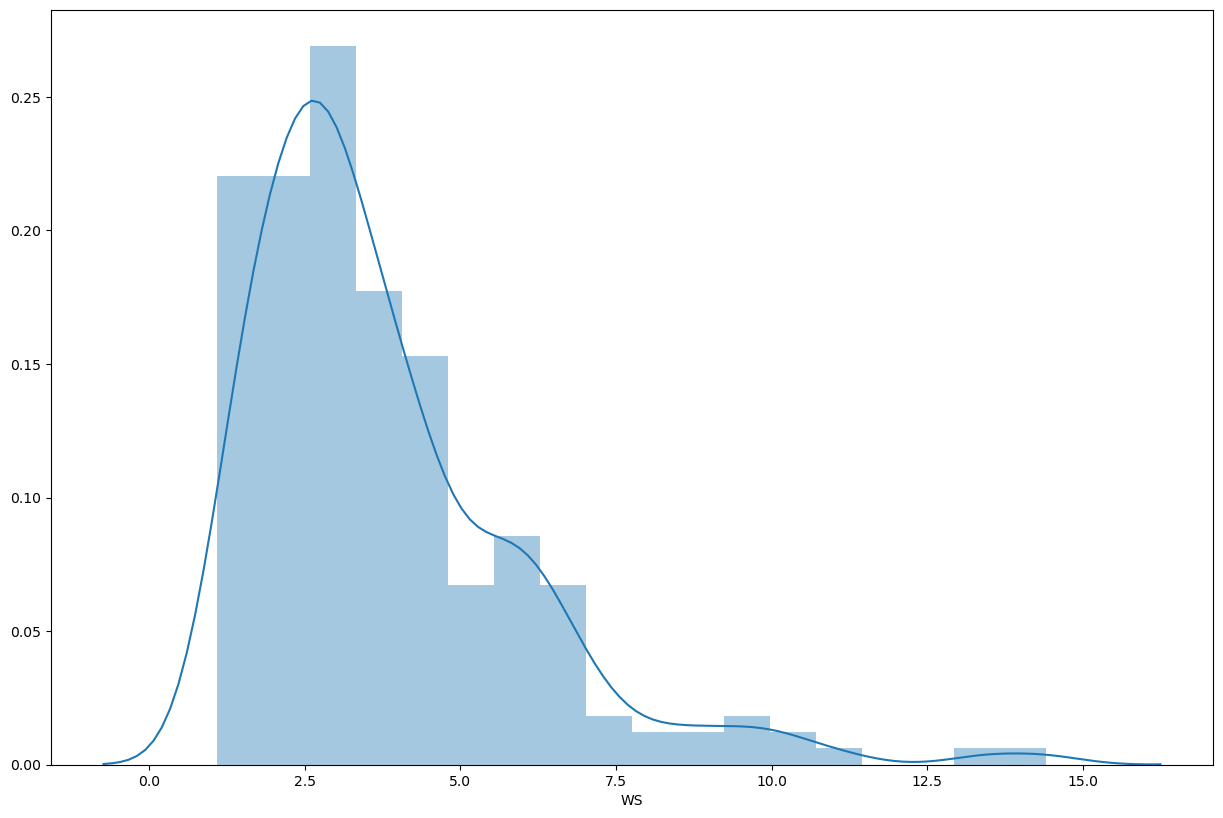

In [91]:
# let's look at the Win Share distribution for the merged data set of athletes who 
# participated in the combine, and their average win share for their 58 game seasons

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(combine_subset['WS'])


Winshare for our combine data appears to be near a normal distribution, and we see the expected pattern of things being skewed right.

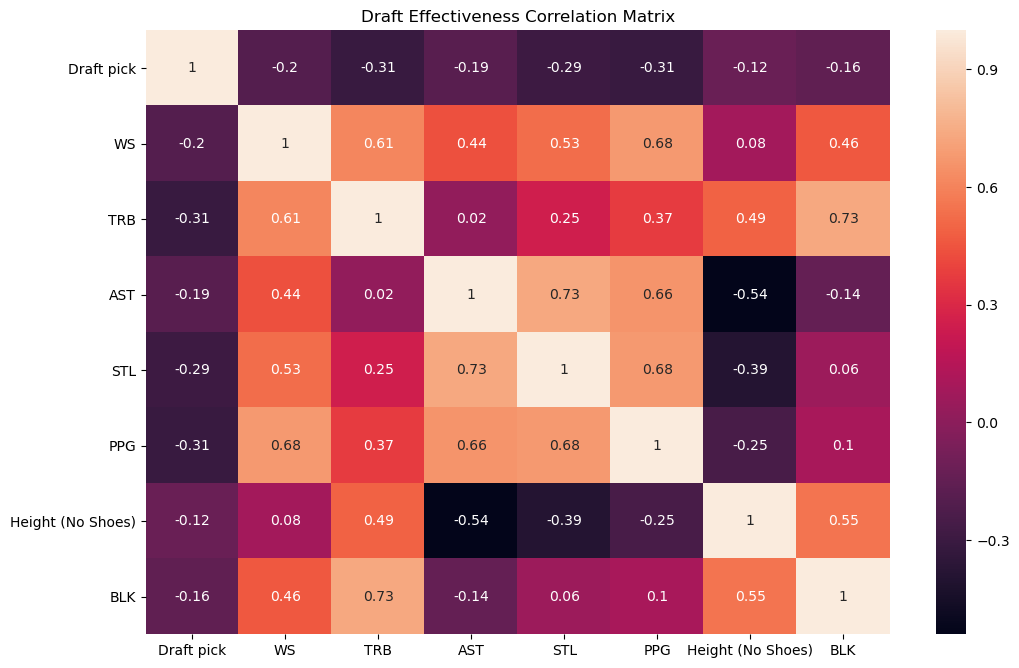

In [92]:
# plot a correlation matrix 

draft_corr = combine_subset.corr().round(2)
sns.heatmap(data=draft_corr, annot=True)
plt.title('Draft Effectiveness Correlation Matrix')
plt.savefig('visualizations/draft_correlations.png', bbox_inches='tight', 
            pad_inches=0.1)


Looking at the correlation matrix, we see that the correlation between draft position and stats like PPG, STL and is weak at best, there is a relationship, but it isn't significant. Let's look at linear model plot of this data 


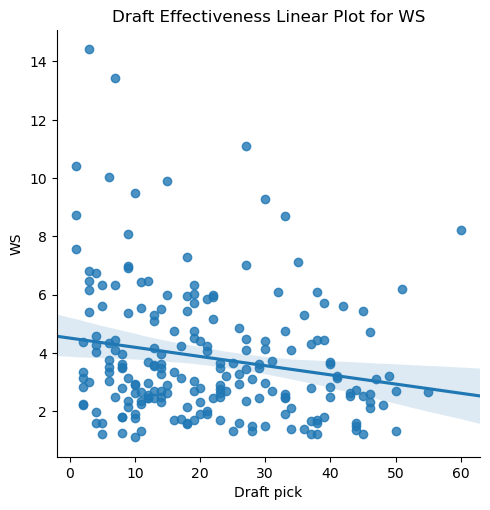

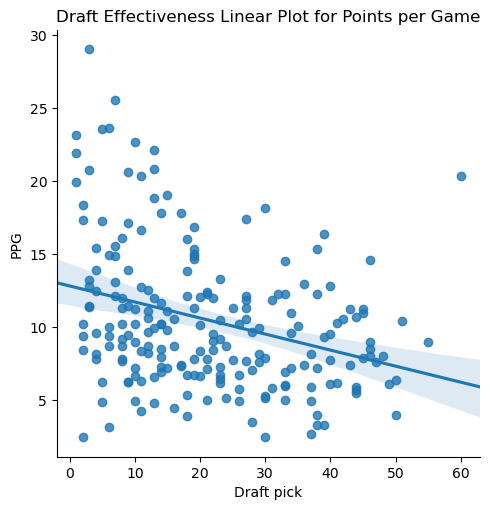

In [93]:
# linear plot to visualize the correlation between draft position and win share

sns.lmplot(x='Draft pick', y='WS', data=combine_subset)
plt.title('Draft Effectiveness Linear Plot for WS')
plt.savefig('visualizations/draft_plot.png', bbox_inches='tight', 
            pad_inches=0.1)

# linear plot to visualize the correlation between draft position and PPG
sns.lmplot(x='Draft pick', y='PPG', data=combine_subset)
plt.title('Draft Effectiveness Linear Plot for Points per Game')
plt.savefig('visualizations/draft_ppg_plot.png', bbox_inches='tight', 
            pad_inches=0.1)

The relationship we see is that while the top players in the league do tend to have been first round or low draft picks not all low draft picks turn out to be great players. Looking at the graph the trend seems to be that high performing first round draft picks are outliers, while just being above average looks to be 50/50 odds. From our earlier analysis we know that average PPG is 11.2 and average win share is 4.43, so let's evaluate just how many of those players perform above average. 


In [94]:
# first we isolate the athletes taken in the top 15% of the draft 

high_draft = combine_subset[(combine_subset['Draft pick'] <= 15)]
high_draft.shape

(89, 8)

We had 227 total athletes and 89 or 39% were taken in the top 25% (first 15 picks) of the draft, which gives us another finding: regardless of performance trends, higher draft picks do tend to be more likely to play a 58 game season. This isn't particularly surprising given the investment teams make into those players. 

In [107]:
# nba_subset.loc[:,'PPG'] = nba_subset['PTS'] / nba_subset['G']

# add columns for above average, below average, top 25%, not top 25% to make counting in each category
# as well as calculating sample proportions for the purposes of statistical signifigance tests easier. 

# add the above_average, below average columns 


avg_ws = nba_subset['WS'].mean()
avg_ppg = nba_subset['PPG'].mean()


high_draft.loc[:, 'ws_above_average'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x <= avg_ws else 1)
high_draft.loc[:, 'ws_below_average'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x >= avg_ws else 1)
high_draft.loc[:, 'ppg_above_average'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x <= avg_ppg else 1)
high_draft.loc[:, 'ppg_below_average'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x >= avg_ppg else 1)


high_draft

,Draft pick,WS,TRB,AST,STL,PPG,Height (No Shoes),BLK,ws_above_average,ws_below_average,ppg_above_average,ppg_below_average
0,3.0,14.414286,464.142857,600.142857,136.428571,29.040460,76.00,46.285714,1,0,1,0
1,7.0,13.416667,356.833333,539.333333,136.666667,25.548036,74.00,16.500000,1,0,1,0
3,1.0,10.400000,705.666667,127.333333,91.833333,23.184079,81.25,164.333333,1,0,1,0
4,6.0,10.042857,327.000000,497.000000,76.142857,23.635619,73.75,24.428571,1,0,1,0
5,15.0,9.883333,430.166667,172.000000,121.000000,19.074851,78.00,46.666667,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
198,5.0,1.600000,307.000000,34.000000,23.000000,4.842857,79.75,20.000000,0,1,0,1
211,11.0,1.300000,437.000000,441.000000,130.000000,16.671429,76.75,43.000000,0,1,1,0
215,8.0,1.250000,176.500000,134.500000,33.000000,7.658824,77.25,19.500000,0,1,0,1
219,5.0,1.200000,132.000000,111.000000,21.000000,6.242424,76.50,12.000000,0,1,0,1


In [97]:
# count how many athletes above average for WS 

ws_above_count = high_draft['ws_above_average'].sum()
ws_below_count = high_draft['ws_below_average'].sum()

ws_above_count

29

In [98]:
# count how many athletes above average for PPG and calculate N 

ppg_above_count = high_draft['ppg_above_average'].sum()
ppg_below_count = high_draft['ppg_below_average'].sum()
n = len(high_draft)


In [99]:
import statsmodels.api as sm

# null hypothesis: 50/50 chance of selecting an above average player or 
# an average player in the top 15 picks of the draft 
# alternate hypothesis: the % of top 15 draft picks that are high scorers will 
# be greater than those that are low scorers 


pnull = 0.50
phat = ppg_above_count/n

# ppg_null


sm.stats.proportions_ztest(phat * n, n, pnull, alternative='larger')




(-0.3181801767452045, 0.6248258656583483)

Looking the above we see that with a p-value of 0.625 we can't reject the null hypothesis, meaning: in all likelihood the NBA's evaluation procedures are a little better than a coin flip. 

In [109]:
high_draft.loc[:, 'ws_above_75th%'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x <= 5.7 else 1)
high_draft.loc[:, 'ws_below_75th%'] = high_draft.loc[:,'WS'].apply(lambda x: 0 if x >= 5.7 else 1)
high_draft.loc[:, 'ppg_above_75th%'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x <= 14.13 else 1)
high_draft.loc[:, 'ppg_below_75th%'] = high_draft.loc[:,'PPG'].apply(lambda x: 0 if x >= 14.13 else 1)


high_draft

,Draft pick,WS,TRB,AST,STL,PPG,Height (No Shoes),BLK,ws_above_average,ws_below_average,ppg_above_average,ppg_below_average,ws_above_75th%,ws_below_75th%,ppg_above_75th%,ppg_below_75th%
0,3.0,14.414286,464.142857,600.142857,136.428571,29.040460,76.00,46.285714,1,0,1,0,1,0,1,0
1,7.0,13.416667,356.833333,539.333333,136.666667,25.548036,74.00,16.500000,1,0,1,0,1,0,1,0
3,1.0,10.400000,705.666667,127.333333,91.833333,23.184079,81.25,164.333333,1,0,1,0,1,0,1,0
4,6.0,10.042857,327.000000,497.000000,76.142857,23.635619,73.75,24.428571,1,0,1,0,1,0,1,0
5,15.0,9.883333,430.166667,172.000000,121.000000,19.074851,78.00,46.666667,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,5.0,1.600000,307.000000,34.000000,23.000000,4.842857,79.75,20.000000,0,1,0,1,0,1,0,1
211,11.0,1.300000,437.000000,441.000000,130.000000,16.671429,76.75,43.000000,0,1,1,0,0,1,1,0
215,8.0,1.250000,176.500000,134.500000,33.000000,7.658824,77.25,19.500000,0,1,0,1,0,1,0,1
219,5.0,1.200000,132.000000,111.000000,21.000000,6.242424,76.50,12.000000,0,1,0,1,0,1,0,1


In [114]:
# count number of athletes taken in the top 25% of the draft that produce win shares in the 75th percentile:

ws_above_count = high_draft['ws_above_75th%'].sum()
ws_above_count_per = ws_above_count/n 

print('# of athletes who produced win shares in the 75th percentile:', ws_above_count)
print('% of athletes who produced win shares in the 75th percentile:', ws_above_count_per)


# of athletes who produced win shares in the 75th percentile: 20
% of athletes who produced win shares in the 75th percentile: 0.2247191011235955


In [116]:
ppg_above_count = high_draft['ppg_above_75th%'].sum()
ppg_above_count_per = ppg_above_count/n 

print('# of athletes who produced win shares in the 75th percentile:', ppg_above_count)
print('% of athletes who produced win shares in the 75th percentile:', ppg_above_count_per)

# of athletes who produced win shares in the 75th percentile: 26
% of athletes who produced win shares in the 75th percentile: 0.29213483146067415


Let's summarize the current findings: 

* Only 29/89 athletes taken in the top 15 picks of the draft were at or above average in terms of win share or roughly 32%. 
* 43/89 athletes were above average in terms of PPG, but according to our statistical significance tests, the difference between above and below average isn't statistically significant. Meaning: when it comes to PPG it's roughly 50/50 whether or not a top 15 draft pick scores more than average 
* 89/227 athletes were picked in the top 25% of the draft or 40% of our athletes, the number would've been 25% if every draft position had an equal chance of playing at least one 58 game season. This means that at the very least, higher draft picks get more playing time, probably due to some combination of the team's investment, expectations and talent. 
* 22.47% of the athletes (20 total) selected in the top 15 of the draft will produce win shares in the 75th percentile 
* 29.21% of the athletes (26 total) selected in the top 15 of th draft will produce PPG in the 75th percentile 

In [100]:
# analyze the data with just the data we have full combine data for 

full_combine = combine_nba_merge.dropna()
full_combine.shape


(99, 31)

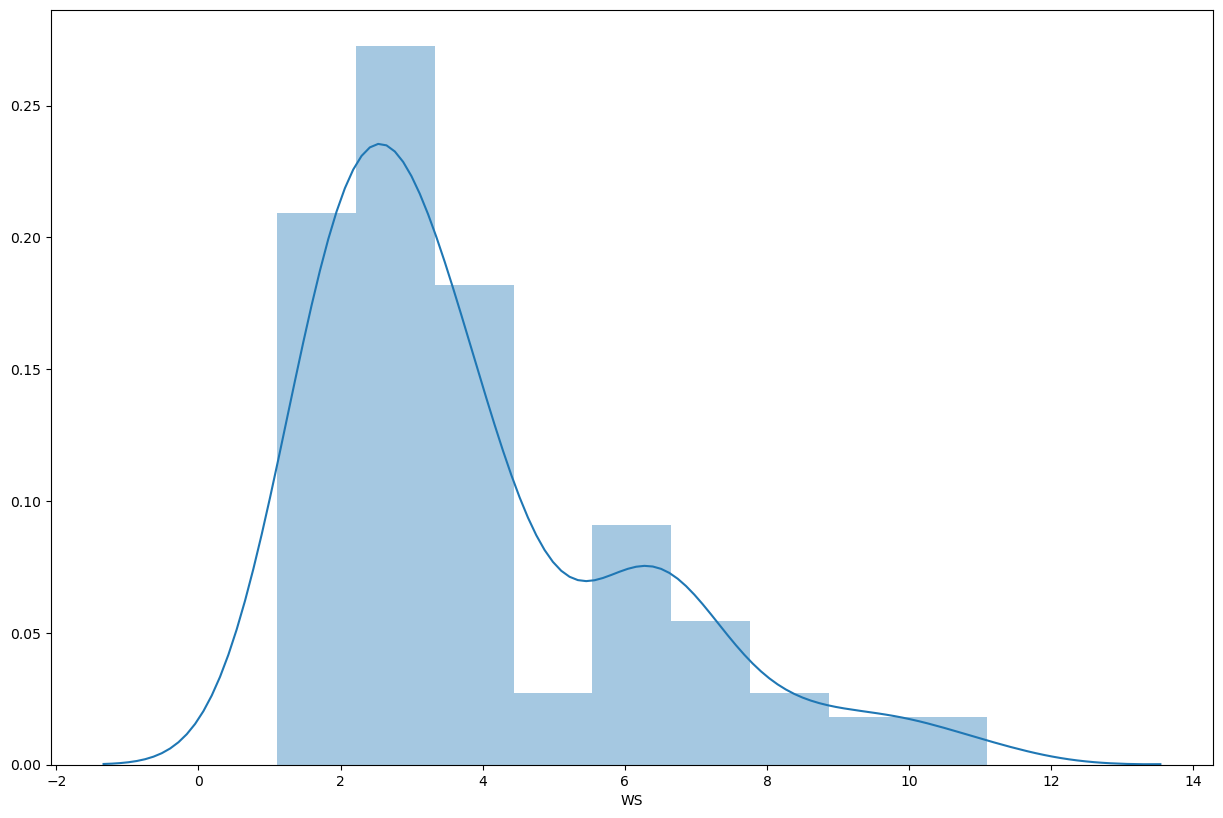

In [101]:
# let's take a look at the Win Share distribution 

plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(full_combine['WS'])



Text(0.5, 1.0, 'Do Combine Measurements Correlate to In Game Performance?')

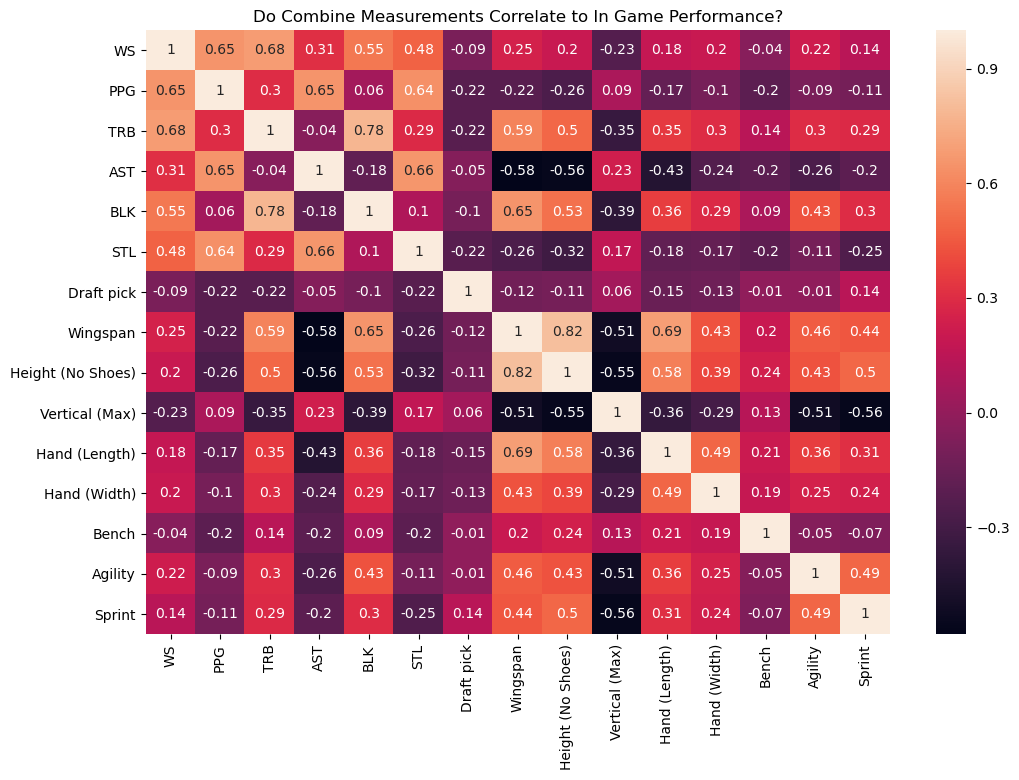

In [104]:

# compute correlation matrix

combine_correlation = full_combine[['WS', 'PPG', 'TRB', 'AST', 'BLK', 'STL', 'Draft pick', 'Wingspan', 'Height (No Shoes)', 'Vertical (Max)', 'Hand (Length)',
                                    'Hand (Width)', 'Bench', 'Agility', 'Sprint']]

combine_corr = combine_correlation.corr().round(2)
sns.heatmap(data=combine_corr, annot=True)
plt.title('Do Combine Measurements Correlate to In Game Performance?')


According to the correlation matrix there doesn't seem to be a strong correlation between any of the selected combine measurements and win share or PPG, as the "strongest" coefficients were:

* 0.25 for wingspan and winshare 
* 0.22 for agility and winshare 
* -0.23 for vertical leap and winshare 
* -0.22 and -0.26 for PPG vs. wingspan and height respectively 

We also had some near strong coefficients for in game stats outside of our primary ones: 
* 0.65 for wingspan and blocks 
* 0.59 for wingspan and total rebounds 
* 0.53 for height and blocks 


We also have some other relationships that are "stronger" than most, but those are probably more a factor of the bodytypes that play certain positions. 

* -0.58 and -0.56 for wingspan and height respectively vs. assists, which is probably more a reflection of the fact that players that play positions like point guard tend to be shorter than larger athletes that play center or power forward. 

Going back to the Kevin Durant example, bench press had the weakest relationships of any combine measurement with win share and PPG (-0.04 and -0.2 respectively), supporting Kevin's claim that it was a pointless exercise. 

The strongest relationships were between the dependent variables themselves, things such as:
* Height and wingspan(0.82)
* Hand width and wingspan (0.69) 

If we were going to do a regression or similar analysis we might have to take certain correlated independent variables out to avoid collinearity, but we don't have a strong enough relationship between WS or PPG to pursue that avenue. We also don't see a strong correlation between any of the combine measurements and draft position. 



Text(0.5, 1.0, 'Agility vs. WS')

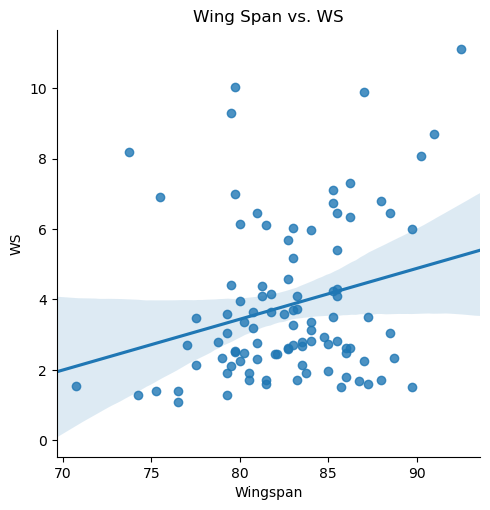

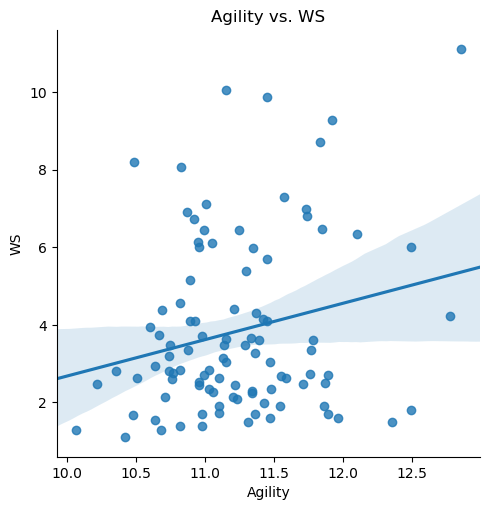

In [54]:
# what does a linear plot look like for the strongest correlators for win share? 

# linear plot to visualize the correlation between WS and Wingspan
sns.lmplot(x='Wingspan', y='WS', data=combine_correlation)
plt.title('Wing Span vs. WS')


# linear plot to visualize the correlation between WS and Agility
sns.lmplot(x='Agility', y='WS', data=combine_correlation)
plt.title('Agility vs. WS')

Summarizing all of our findings: 
 
* 22.47% of the athletes (20 total) selected in the top 15 of the draft will produce win shares in the 75th percentile 
* 29.21% of the athletes (26 total) selected in the top 15 of th draft will produce PPG in the 75th percentile 
* There doesn't seem to be any significant relationship between the combine measurements and win share or PPG
* There are not quite strong, but "good" relationships between height and wing span and rebounding and shot blocks, but it's not at the level of strong. 
* The game's best players are usually top draft picks, but a top draft pick is not necessarily going to be a top player. 
* Only 29/89 (32%) athletes taken in the top 15 picks of the draft were at or above average in terms of win share
* 43/89 athletes were above average in terms of PPG, but according to our statistical significance tests, the difference between above and below average isn't statistically significant. Meaning: when it comes to PPG it's roughly 50/50 whether or not a top 15 draft pick scores more than average 
* 89/227 athletes were picked in the top 25% of the draft or 40% of our athletes, the number would've been 25% if every draft position had an equal chance of playing at least one 58 game season. This means that at the very least, higher draft picks get more playing time, probably due to some combination of the team's investment, expectations and talent. 

Overall it doesn't appear that the NBA has the "formula" to identify above average players, because while the best players do tend to be high draft picks, high draft picks as a group have at best a 50/50 chance of being above average and the number drops to under 30% if you're looking at the 75th percentile. Looking at individual evaluation methods like the draft, we couldn't find any significant relationship between combine events and in game performance aside from height and wingspan vs blocks and rebounds. However, it's worth pointing out that one can't "train" to give a better performance on their height or arm length measurements, so the events one can prepare for like speed, agility, strength and jumping, there is no real relevance to in game performance. While our data set was small and barely spanned a decade, it does appear on a preliminary basis that Kevin Durant was right. 

    


Future Improvements:

1. Get a broader dataset that has at least 20 years of player statistics including win share and draft position 
2. Use the above to re-analyze draft position vs. in game performance 
3. Acquire 20 years of combine data to see if the trends change with more data 
4. Create a visualization showing how many players from a given draft were above average, to see if the NBA's evaluation methods have improved over time
5. See if I can repeat the above for the WNBA to see if this trends hold up for the Woman's league as well 

